In [69]:
import time

# Obróbka danych
import pandas as pd
import numpy as np

# Wizualizacja 
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mgno 

# Przygotowanie danych 
from hyperopt import hp, fmin, tpe, STATUS_OK, space_eval
from hyperopt import Trials
from sklearn.model_selection import cross_val_score
from fast_ml.model_development import train_valid_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer, OrdinalEncoder, OneHotEncoder, Normalizer
from IPython.display import display, HTML
from sklearn.metrics import confusion_matrix,accuracy_score

# Modele
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb


# Wyświetlanie notebooka
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

# Wizualizacje wykresów
fontdict = {'family': 'Times New Roman',
        'color':  'black',
        'weight': 'normal',
        'size': 25,
        }
from warnings import filterwarnings
filterwarnings('ignore')

In [70]:
df = pd.read_csv("./water_potability.csv")
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


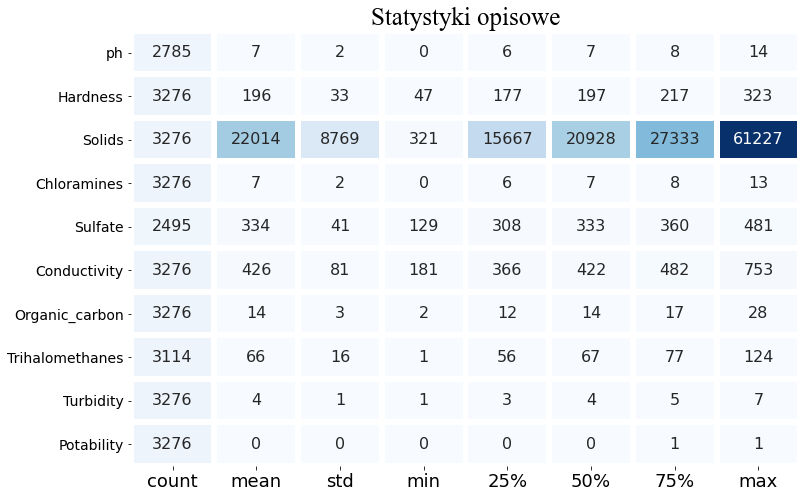

In [71]:
desc = df.describe().T
f,ax = plt.subplots(figsize=(12,8))
sns.heatmap(desc,annot=True,cmap = "Blues", fmt= '.0f',
            ax=ax,linewidths = 5, cbar = False,
            annot_kws={"size": 16})
plt.xticks(size = 18)
plt.yticks(size = 14, rotation = 0)
plt.title("Statystyki opisowe", fontdict=fontdict)
plt.show()

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


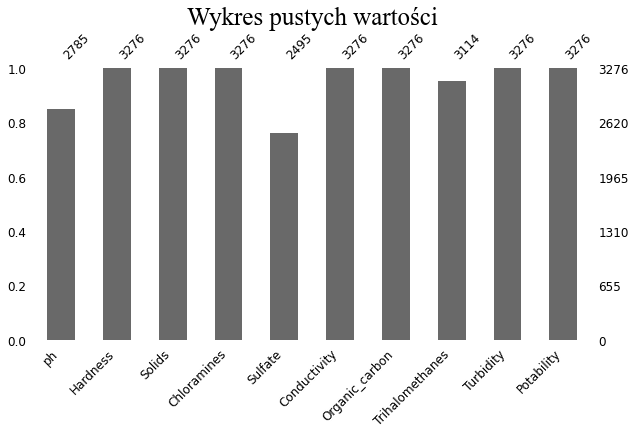

In [73]:
mgno.bar(df, figsize=(10,5), fontsize=12);
plt.title('Wykres pustych wartości',fontdict=fontdict)
plt.show()
#print(df.isnull().sum())

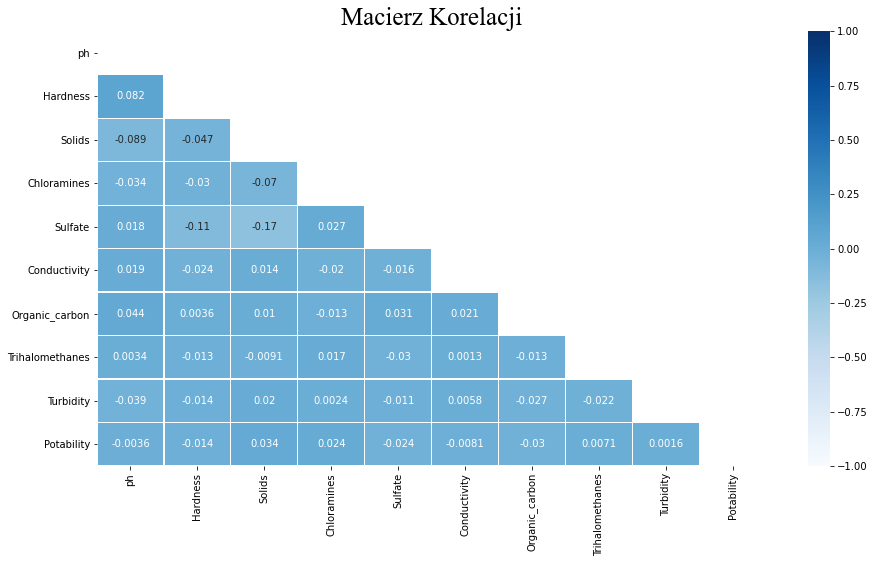

In [74]:
plt.figure(figsize=(15,8))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True,linewidths=0.2,vmin=-1,vmax=1,mask=mask, cmap='Blues',center=0,)
plt.title('Macierz Korelacji',fontdict=fontdict)
plt.show()

In [75]:
cols = df.columns[:-1]
for col in cols:
    print("{} = {}".format(col,df[col].skew()))

ph = 0.025630447632210302
Hardness = -0.03934170477672744
Solids = 0.6216344855169127
Chloramines = -0.012098440124382135
Sulfate = -0.03594662160706183
Conductivity = 0.2644902239264119
Organic_carbon = 0.02553258209024246
Trihalomethanes = -0.08303067407901549
Turbidity = -0.007816642377392644


In [76]:
cols = df.columns[:-1]
threshold = 0.2
cols_threshold = []

for col in cols:
    if df[col].skew() > threshold:
        cols_threshold.append(col)
    else:
        pass

for col in cols_threshold:
    df[col + "_sqrt"] = np.sqrt(df[col])
    
df.drop(cols_threshold,axis="columns",inplace=True)

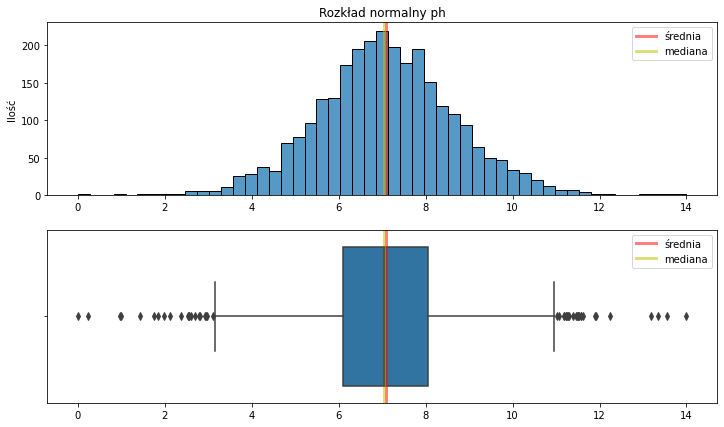

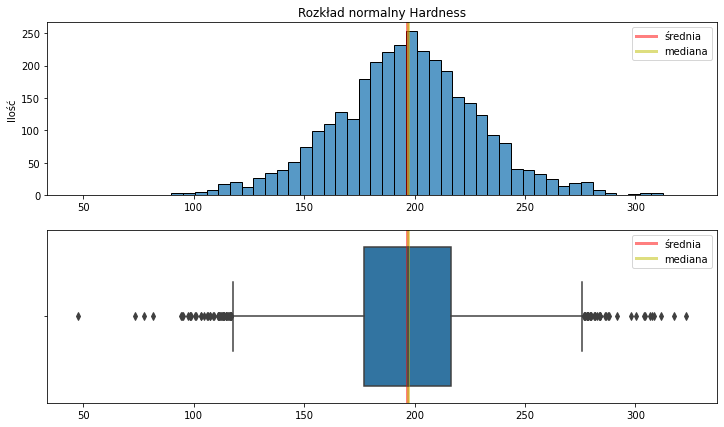

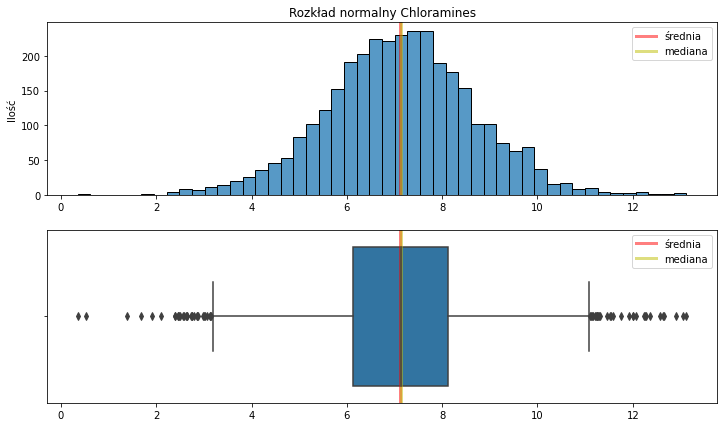

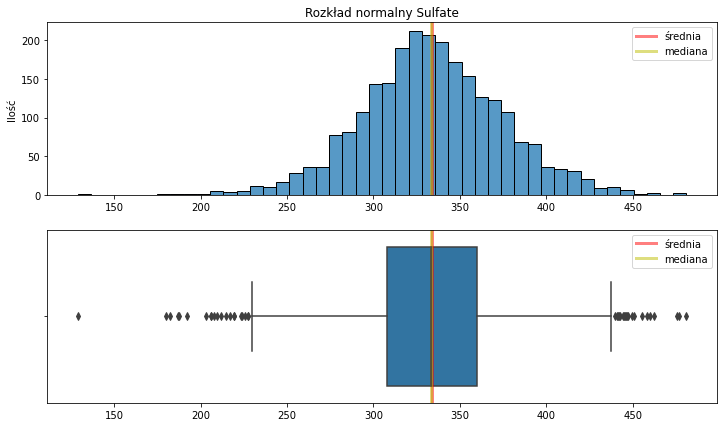

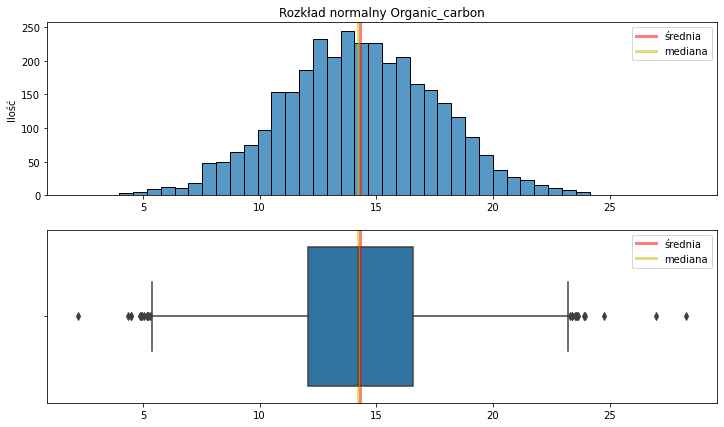

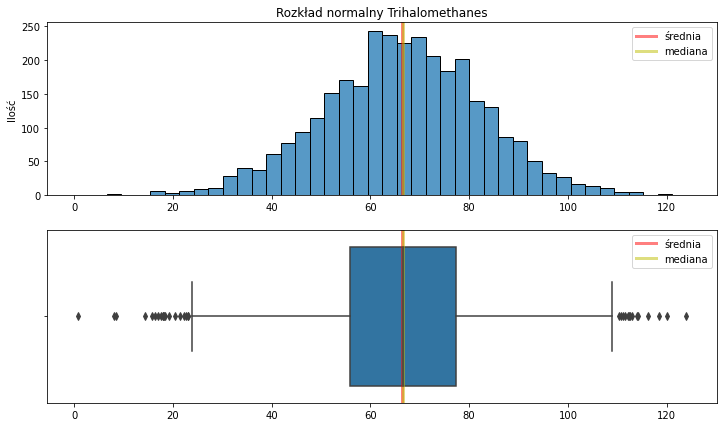

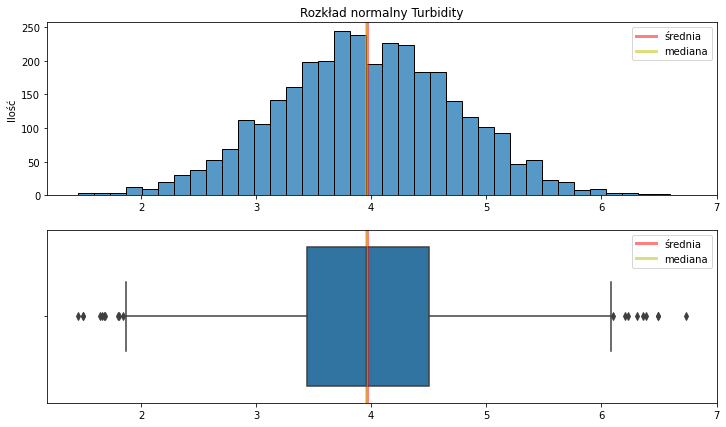

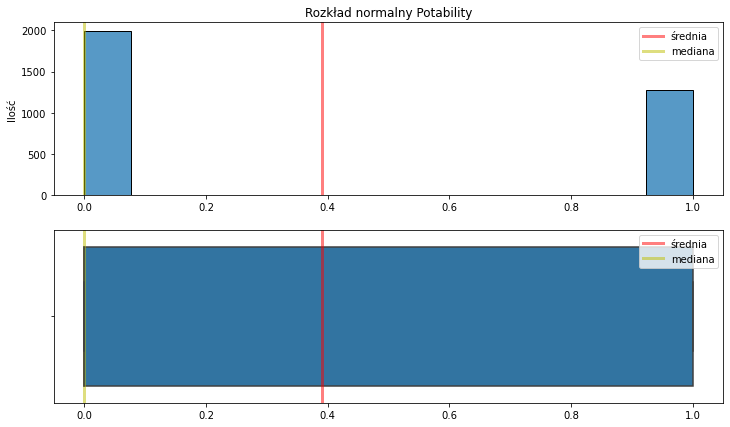

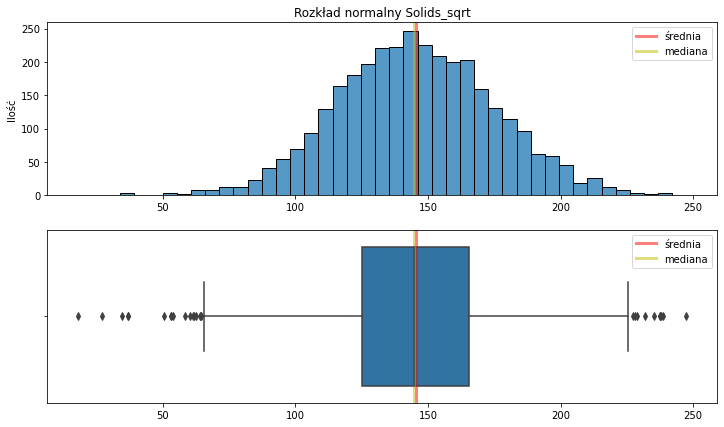

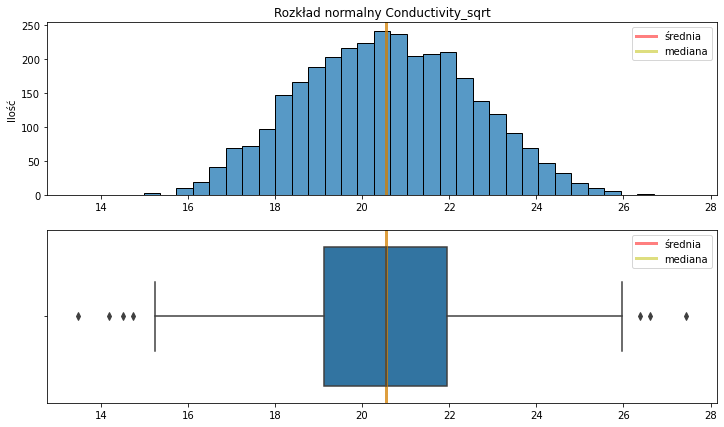

In [77]:
cols = df.columns
for col in cols:
    fig, axes = plt.subplots(2, 1,figsize=(12, 7))
    
    axes[0].axvline(x=df[col].mean(), linewidth=3, color='r', label="mean", alpha=0.5,)
    axes[0].axvline(x=df[col].median(), linewidth=3, color='y', label="median", alpha=0.5,)
    sns.histplot(df[col],ax=axes[0])
    
    axes[1].axvline(x=df[col].mean(), linewidth=3, color='r', label="mean", alpha=0.5,)
    axes[1].axvline(x=df[col].median(), linewidth=3, color='y', label="median", alpha=0.5,)
    sns.boxplot(x=df[col],ax=axes[1])

    axes[0].set_ylabel('Ilość')
    axes[0].set_xlabel('')
    axes[0].set_title("Rozkład normalny {}".format(col))
    axes[0].legend(["średnia", "mediana"])
    axes[1].legend(["średnia", "mediana"])
    axes[1].set_xlabel('')

In [78]:
cols = df.columns
for col in cols:
    print("{} = {}".format(col,df[col].skew()))

ph = 0.025630447632210302
Hardness = -0.03934170477672744
Chloramines = -0.012098440124382135
Sulfate = -0.03594662160706183
Organic_carbon = 0.02553258209024246
Trihalomethanes = -0.08303067407901549
Turbidity = -0.007816642377392644
Potability = 0.4507837491078628
Solids_sqrt = -0.015157793420941923
Conductivity_sqrt = 0.031893328896820373


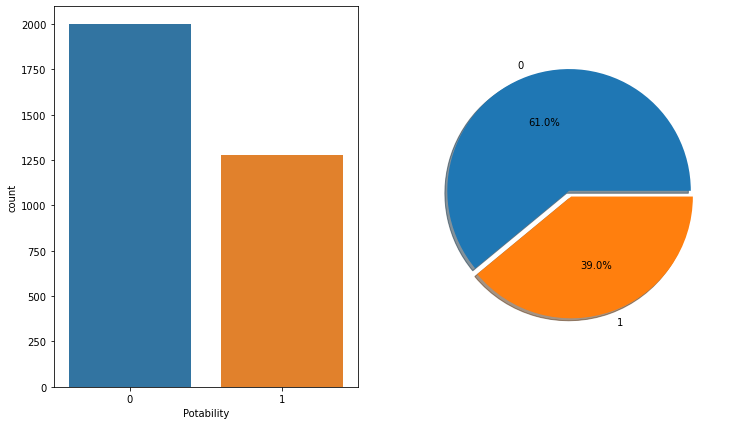

In [79]:
fig, axes = plt.subplots(1, 2,figsize=(12, 7))
ax.set_title("Ilość próbki Potability")
sns.countplot(x ='Potability', data = df,ax=axes[0],)
counts = df.Potability.value_counts()
plt.pie(counts, explode = (0.05, 0), autopct='%1.1f%%',labels=counts.index, shadow=True);

Do zrobienia:
- Wypełnić puste wartości
- Zbalansować kolumne Potability

In [80]:
df = df[['ph', 'Hardness', 'Chloramines', 'Sulfate', 'Organic_carbon','Trihalomethanes', 'Turbidity','Solids_sqrt'
         ,'Conductivity_sqrt','Potability']]

In [81]:
df.head()

,ph,Hardness,Chloramines,Sulfate,Organic_carbon,Trihalomethanes,Turbidity,Solids_sqrt,Conductivity_sqrt,Potability
0,NaN,204.890455,7.300212,368.516441,10.379783,86.990970,2.963135,144.191952,23.755182,0
1,3.716080,129.422921,6.635246,NaN,15.180013,56.329076,4.500656,136.491970,24.349237,0
2,8.099124,224.236259,9.275884,NaN,16.868637,66.420093,3.055934,141.101176,20.459868,0
3,8.316766,214.373394,8.059332,356.886136,18.436524,100.341674,4.628771,148.386042,19.059552,0
4,9.092223,181.101509,6.546600,310.135738,11.558279,31.997993,4.075075,134.085742,19.960231,0


In [84]:
nominal_pipeline = Pipeline([
    ('nominal_inputer', SimpleImputer(missing_values=np.nan, strategy='constant'))
])

In [85]:
nominal_transformed = nominal_pipeline.fit_transform(df)
nominal_transformed = pd.DataFrame(nominal_transformed, columns = df.columns)
nominal_transformed.head()

,ph,Hardness,Chloramines,Sulfate,Organic_carbon,Trihalomethanes,Turbidity,Solids_sqrt,Conductivity_sqrt,Potability
0,0.000000,204.890455,7.300212,368.516441,10.379783,86.990970,2.963135,144.191952,23.755182,0.0
1,3.716080,129.422921,6.635246,0.000000,15.180013,56.329076,4.500656,136.491970,24.349237,0.0
2,8.099124,224.236259,9.275884,0.000000,16.868637,66.420093,3.055934,141.101176,20.459868,0.0
3,8.316766,214.373394,8.059332,356.886136,18.436524,100.341674,4.628771,148.386042,19.059552,0.0
4,9.092223,181.101509,6.546600,310.135738,11.558279,31.997993,4.075075,134.085742,19.960231,0.0


In [62]:
target=df.columns[-1]
features = nominal_transformed.iloc[:,:-1]

In [63]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(nominal_transformed, target = target ,train_size=0.8, valid_size=0.1, test_size=0.1,random_state=42)
print(X_train.shape,y_train.shape)
print(X_valid.shape,y_valid.shape)
print(X_test.shape,y_test.shape)

(2620, 9) (2620,)
(328, 9) (328,)
(328, 9) (328,)


(3172, 9) (3172,)


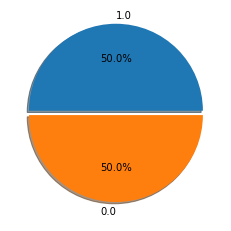

In [64]:
#Oversampling
over_sampler = RandomOverSampler(random_state=42)
X_train, y_train = over_sampler.fit_resample(X_train, y_train)
print(X_train.shape,y_train.shape)
counts = y_train.value_counts()
plt.pie(counts, explode = (0.05, 0), autopct='%1.1f%%',labels=counts.index, shadow=True);

In [66]:
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns

numerical_pipeline = Pipeline([
    ('numerical_imputer', SimpleImputer(strategy='median')),
    ('numerical_transformer', StandardScaler()),
])

data_processing_pipeline = ColumnTransformer(
    transformers=[
        ('numerical_pipeline', numerical_pipeline, numerical_columns)])

data_processing_pipeline.fit(X_train)

ColumnTransformer(transformers=[('numerical_pipeline',
                                 Pipeline(steps=[('numerical_imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('numerical_transformer',
                                                  StandardScaler())]),
                                 Index(['ph', 'Hardness', 'Chloramines', 'Sulfate', 'Organic_carbon',
       'Trihalomethanes', 'Turbidity', 'Solids_sqrt', 'Conductivity_sqrt'],
      dtype='object'))])

In [67]:
X_train.head()

,ph,Hardness,Chloramines,Sulfate,Organic_carbon,Trihalomethanes,Turbidity,Solids_sqrt,Conductivity_sqrt
0,6.623614,203.030141,6.049601,311.726288,15.914500,65.021229,2.915166,131.024049,20.254462
1,6.684700,193.840931,9.876574,344.535407,8.818757,66.659352,4.030660,184.816624,22.317347
2,6.836060,205.667718,6.712854,297.837188,13.808923,70.714225,4.952508,135.356298,22.237002
3,0.000000,183.488839,9.777807,319.870584,13.309723,46.853410,3.240419,112.587472,21.964631
4,6.406798,182.885137,7.462758,332.486731,17.301617,64.070236,4.573968,133.607874,19.969470


In [353]:
"""classifiers_1 = [
                BaggingClassifier(random_state=42),
                RandomForestClassifier(random_state=42),
                xgb.XGBClassifier(random_state=42,eval_metric = "mlogloss"),
                GradientBoostingClassifier(random_state=42)
              ]"""


In [95]:
"""models_df = pd.DataFrame()
 
pipe = Pipeline(steps = [
    ('data_processing_pipeline', data_processing_pipeline),
    ('classifier', None)
])
 
for model in classifiers_1:
    pipe_params = {
                        'classifier': model
                  }
    pipe.set_params(**pipe_params)
    start_time = time.time()
    pipe.fit(X_train, y_train)
    end_time = time.time()
    
    score = pipe.score(X_test, y_test)
    param_dict = {
                        'model': model.__class__.__name__,
                        'wynik': score,
                        'czas_wykonywania': end_time - start_time
                 }
    models_df = models_df.append(pd.DataFrame(param_dict, index=[0]))
    
models_df.reset_index(drop=True, inplace=True);"""

In [85]:
"""models_df.sort_values('wynik', ascending=False)"""

,model,wynik,czas_wykonywania
1,RandomForestClassifier,0.716463,0.671239
0,BaggingClassifier,0.710366,0.164526
2,XGBClassifier,0.664634,0.364990
3,GradientBoostingClassifier,0.652439,0.745039


In [86]:
"""models_df[['model', 'wynik', 'czas_wykonywania']] \
    .groupby('model') \
    .aggregate({
        'wynik': ['mean', 'min', 'max'],
        'czas_wykonywania': ['mean', 'min', 'max']
        }) \
    .reset_index() \
    .sort_values(('wynik', 'mean'), ascending=False)"""

model     wynik                     czas_wykonywania  \
                                   mean       min       max             mean   
2      RandomForestClassifier  0.716463  0.716463  0.716463         0.671239   
0           BaggingClassifier  0.710366  0.710366  0.710366         0.164526   
3               XGBClassifier  0.664634  0.664634  0.664634         0.364990   
1  GradientBoostingClassifier  0.652439  0.652439  0.652439         0.745039   

                       
        min       max  
2  0.671239  0.671239  
0  0.164526  0.164526  
3  0.364990  0.364990  
1  0.745039  0.745039

In [441]:
classifiers = [
        {
        'name': 'BaggingClassifier()',
        'class': BaggingClassifier(),
        'max_evals': 100,
        'params': {
            'n_estimators': hp.uniformint('n_estimators', 100, 500),
            'random_state' : 42
           }
    },
    {
        'name': 'RandomForestClassifier()',
        'class': RandomForestClassifier(),
        'max_evals': 100,
        'params': {
            'n_estimators': hp.uniformint('n_estimators', 100, 500),
            'max_depth': hp.uniformint('max_depth', 2, 20),
            'random_state' : 42
           }
    },
     {
        'name': 'GradientBoostingClassifier()',
        'class': GradientBoostingClassifier(),
        'max_evals': 100,
        'params': {
            'n_estimators': hp.uniformint('n_estimators', 100, 500),
            'max_depth': hp.uniformint('max_depth', 2, 20),
            'random_state' : 42
           }
    },
    {
        'name': 'XGBClassifier()',
        'class': xgb.XGBClassifier(eval_metric = "mlogloss"),
        'max_evals': 100,
        'eval_metric': "mlogloss",
        'params' : {
            'learning_rate': hp.loguniform ('learning_rate', 0.01, 0.5),
            'max_depth': hp.choice('max_depth', np.arange(2, 11).tolist()),
            'min_child_weight': hp.choice('min_child_weight', np.arange(0, 101).tolist()),
            'gamma': hp.loguniform('gamma', 0.0, 2.0),
            'subsample': hp.uniform('subsample', 0.5, 1.0),
            'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
            'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1.0),
            'reg_alpha': hp.loguniform('reg_alpha', 0.0, 2.0),
            'reg_lambda': hp.loguniform('reg_lambda', 0.0, 2.0),
            'random_state' : 42
        }
    }
]

In [442]:
def objective(space):
    pipe_params = {}
    
    for s in space:
        pipe_params[f"classifier__{s}"] = space[s]
        
    pipe.set_params(**pipe_params)
    score = cross_val_score(pipe, X_train, y_train, cv=5, scoring="accuracy").mean()
    
    return {'loss': 1- score, 'status': STATUS_OK, 'accuracy': score}

In [443]:
trials_df = []
 
for cl in classifiers:
    cl_name = cl['class'].__class__.__name__
    print(f"\n\n{cl_name}")
    
    pipe = Pipeline(steps = [
    ('data_processing_pipeline', data_processing_pipeline),
    ('classifier', cl['class'])
    ])
    
    space = {}
    for k in cl['params']:
        space[k] = cl['params'][k]
    
    max_evals = cl['max_evals']
    
    trials = Trials()
    best = fmin(fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=max_evals,
                    trials=trials)
     
    best_params = space_eval(space, best)
    print('\nThe best params:')
    print ("{:<30} {}".format('Parameter','Selected'))
    for k, v in best_params.items():
        print ("{:<30} {}".format(k, v))
    
    for trial in trials.trials:
        trials_df.append({
            'classifier': cl_name,
            'loss': trial['result']['loss'],
            'accuracy': trial['result']['accuracy'],
            'params': trial['misc']['vals']
            })



BaggingClassifier
100%|███████████████████████████████████████████████████████████████████████████████████████████| 100/100 [40:18<00:00, 24.18s/trial, best loss: 0.21907896370997793]

The best params:
Parameter                      Selected
n_estimators                   452
random_state                   42


RandomForestClassifier
100%|███████████████████████████████████████████████████████████████████████████████████████████| 100/100 [14:41<00:00,  8.81s/trial, best loss: 0.21340470453811577]

The best params:
Parameter                      Selected
max_depth                      16
n_estimators                   351
random_state                   42


GradientBoostingClassifier
100%|█████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:39:51<00:00, 59.91s/trial, best loss: 0.21971136888646026]

The best params:
Parameter                      Selected
max_depth                      16
n_estimators                   472
random_state 

In [444]:
trials_df = pd.DataFrame(trials_df)

In [445]:
trials_df.sort_values('accuracy', ascending=False)

,classifier,loss,accuracy,params
140,RandomForestClassifier,0.213405,0.786595,"{'max_depth': [16.0], 'n_estimators': [351.0]}"
113,RandomForestClassifier,0.213405,0.786595,"{'max_depth': [16.0], 'n_estimators': [441.0]}"
165,RandomForestClassifier,0.213720,0.786280,"{'max_depth': [16.0], 'n_estimators': [458.0]}"
190,RandomForestClassifier,0.214035,0.785965,"{'max_depth': [16.0], 'n_estimators': [429.0]}"
167,RandomForestClassifier,0.214351,0.785649,"{'max_depth': [16.0], 'n_estimators': [438.0]}"
...,...,...,...,...
193,RandomForestClassifier,0.407313,0.592687,"{'max_depth': [2.0], 'n_estimators': [403.0]}"
112,RandomForestClassifier,0.407949,0.592051,"{'max_depth': [2.0], 'n_estimators': [204.0]}"
308,XGBClassifier,0.411729,0.588271,"{'colsample_bylevel': [0.8649751751564402], 'c..."
396,XGBClassifier,0.415811,0.584189,"{'colsample_bylevel': [0.8906841656574116], 'c..."


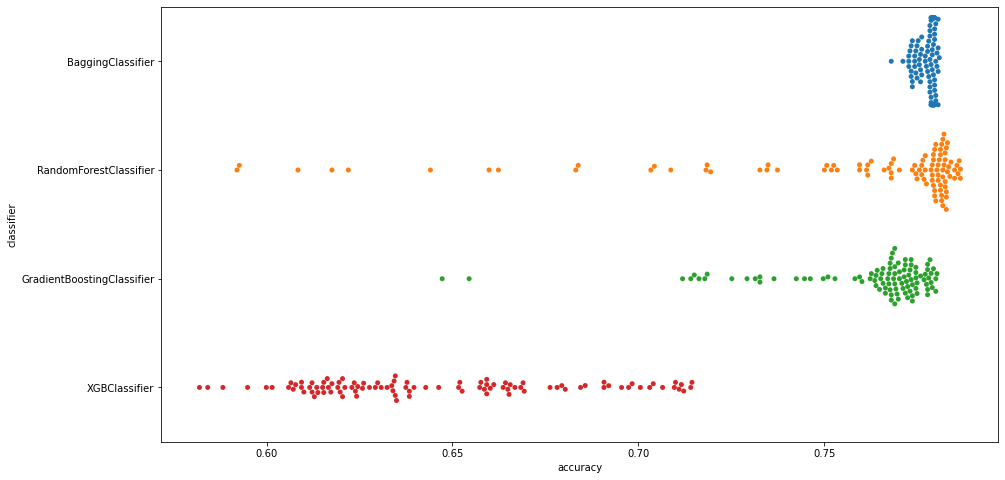

In [446]:
plt.figure(figsize=(15,8))
sns.swarmplot(data=trials_df, y='classifier', x='accuracy');

In [358]:
trials_df.sort_values('accuracy', ascending=False)

,classifier,loss,accuracy,params
191,RandomForestClassifier,0.230429,0.769571,"{'max_depth': [18.0], 'n_estimators': [434.0]}"
124,RandomForestClassifier,0.230431,0.769569,"{'max_depth': [18.0], 'n_estimators': [461.0]}"
104,RandomForestClassifier,0.230743,0.769257,"{'max_depth': [19.0], 'n_estimators': [483.0]}"
128,RandomForestClassifier,0.230745,0.769255,"{'max_depth': [18.0], 'n_estimators': [444.0]}"
175,RandomForestClassifier,0.230745,0.769255,"{'max_depth': [18.0], 'n_estimators': [444.0]}"
...,...,...,...,...
343,XGBClassifier,0.414555,0.585445,"{'colsample_bylevel': [0.964129995568776], 'co..."
306,XGBClassifier,0.418030,0.581970,"{'colsample_bylevel': [0.6021427786881615], 'c..."
361,XGBClassifier,0.418337,0.581663,"{'colsample_bylevel': [0.5375839118977387], 'c..."
138,RandomForestClassifier,0.418350,0.581650,"{'max_depth': [2.0], 'n_estimators': [472.0]}"


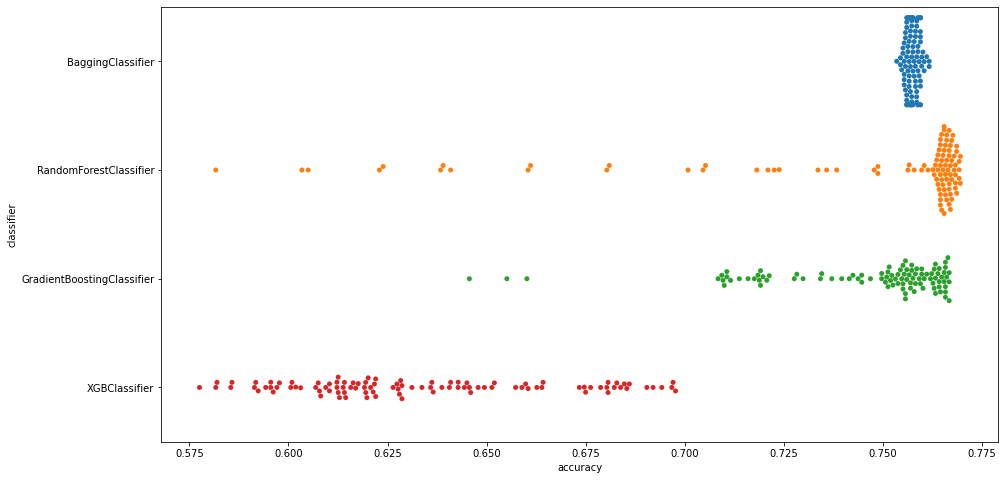

In [359]:
plt.figure(figsize=(15,8))
sns.swarmplot(data=trials_df, y='classifier', x='accuracy');